In [1]:
import glob
import numpy as np
import hyss_util as hu
from datetime import datetime
from sklearn.model_selection import train_test_split
from plotting import set_defaults
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
# -- set the types

kind = "veg"
comp = "bld"

In [3]:
# -- get wavelengths
waves = hu.read_header("../../../image_files/veg_00000.hdr")["waves"]

# -- define good scans
good = np.array([int(i) for i in np.load("../../../gdobler_output/output/good_scans.npy")])

reading and parsing ../../../image_files/veg_00000.hdr...


In [4]:
# -- get vegetation spectra
print("getting {0} spectra...".format(kind))
if kind=="veg":
    vegs = np.load("../../../gdobler_output/output/veg_patch_specs.npy")
else:
    vegs = np.array([np.load(i) for i in
                     sorted(glob.glob("../../../gdobler_output/output/" + 
                                      "{0}_specs/{0}_specs_avg*.npy" \
                                      .format(kind)))])
    vegs = vegs[good]

getting veg spectra...


In [5]:
# -- load comparison set from bld
print("getting {0} spectra...".format(comp))
#try:
#    blds_left = np.load("../../../gdobler_output/output/blds_left.npy")
#except:
blds = np.array([np.load(i) for i in
                sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs_avg*.npy"\
                                .format(comp)))])
blds = blds[good]
# np.save("../../../gdobler_output/output/blds_left.npy",blds)

getting bld spectra...


In [6]:
def normalize_spectra(specs):
    ms, bs = [], []
    for ii in range(specs.shape[0]):
        m = specs[0].mean()/specs[ii].mean()
        b = 0.0
        ms.append(m)
        bs.append(b)
        
    ms   = np.array(ms)
    bs   = np.array(bs)
    norm = specs*ms[:,np.newaxis] + bs[:,np.newaxis]
    rat  = norm/norm[0]
    return rat

In [7]:
# -- normalize spectra

vrat = normalize_spectra(vegs)
brat = normalize_spectra(blds)

In [8]:
print(vrat.shape, brat.shape)

(1102, 848) (1102, 848)


In [9]:
# -- take the ratio of ratios
D_vrat = vrat/brat   # vegetation to buildings
print(D_vrat.shape)

# -- normalize differential ratios
#Dn_vrat = stats.zscore(D_vrat)

(1102, 848)


#### Get air quality data

In [10]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.temperature.values
humid = sc_sub.humidity.values
pm25  = sc_sub.pm25.values
o3    = sc_sub.o3.values
secs  = []
for stime in sc_sub.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt      = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt         = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    secs.append(float(obs_dt.strftime("%s")))
secs = np.array(secs)

In [11]:
opth = pd.DataFrame({'$O_3$': o3, '$PM_{2.5}$': pm25, 'Temperature': temps, 'Humidity':humid})
opth.describe()

,$O_3$,$PM_{2.5}$,Humidity,Temperature
count,1102.000000,1102.000000,1102.000000,1102.000000
mean,0.038318,6.198070,54.506352,68.924592
std,0.014651,3.558875,25.721231,10.497654
min,0.005500,-0.362000,18.000000,46.900000
25%,0.026250,3.569470,33.000000,61.900000
50%,0.038500,5.581250,47.000000,69.100000
75%,0.046500,8.316667,75.000000,76.100000
max,0.086500,17.365833,99.000000,94.500000


Text(0.5,0.95,'Air Quality Scatter Matrix')

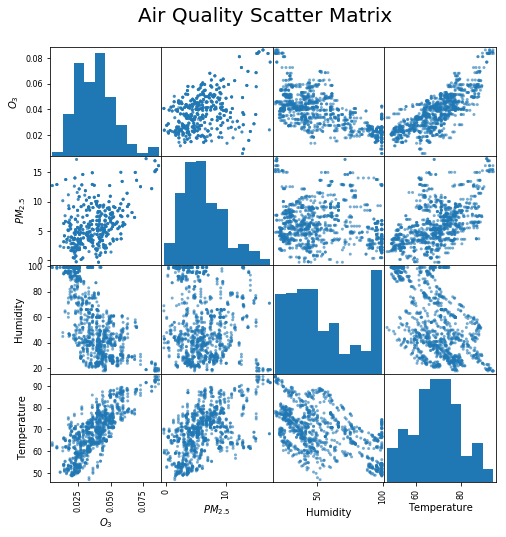

In [12]:
plt.rcParams['font.size'] = 10
#fig, ax = plt.subplots(figsize=[10,10])
mtx = scatter_matrix(opth, alpha=0.6, figsize=(8,8), diagonal='hist')
plt.suptitle("Air Quality Scatter Matrix", y=0.95, fontsize=20)
#plt.savefig("../farid_output/air_quality_scatter_matrix.pdf", dpi=300)
#plt.savefig("../farid_output/air_quality_scatter_matrix.png", dpi=300)

In [13]:
#normalize air quality arrays

o3 = stats.zscore(o3)
pm25 = stats.zscore(pm25)
temps = stats.zscore(temps)
humid = stats.zscore(humid)

aq_opth = np.vstack((o3, pm25, temps, humid)).T
print(aq_opth.shape)

(1102, 4)


In [14]:
# create air quality array

aq_opth = np.vstack((o3, pm25, temps, humid)).T
print(aq_opth.shape)

(1102, 4)


### Split data into train/test sets

In [15]:
Dtrain, Dtest, aqtrain, aqtest = train_test_split(D_vrat, aq_opth, test_size=0.2)

---

## CNN

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers

In [17]:
def CNN_model(in_dim, out_dim, filtersize=50):
    Inputs = keras.Input(shape=(in_dim, 1), name="input_diffratio")
    
    Conv1D_1 = layers.Conv1D(16, kernel_size=(filtersize), padding="same", activation="relu")(Inputs)
    MaxPool_1 = layers.MaxPooling1D((2), strides=2)(Conv1D_1)
    Conv1D_2 = layers.Conv1D(32, kernel_size=(filtersize), padding="same", activation="relu")(MaxPool_1)
    MaxPool_2 = layers.MaxPooling1D((2), strides=2)(Conv1D_2)
    
    #Flatten = layers.Flatten()(MaxPool_2)
    Dropout = layers.Dropout(0.5)(MaxPool_2)
    Flatten = layers.Flatten()(Dropout)
    
    Dense = layers.Dense(512, activation="relu")(Flatten)
    Outputs = layers.Dense(out_dim)(Dense)
    
    model = keras.Model(inputs=[Inputs], outputs=[Outputs])
    
    return model

In [18]:
def plot_loss_history(model):
    f, ((ax1, ax2)) = plt.subplots(1,2,figsize=(10,4))
    ax1.plot(model.history['loss'])
    ax1.plot(model.history['val_loss'])
    ax1.set_title('CNN Model Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.locator_params(nbins=13, axis='x')
    ax1.legend(['train', 'test'])
    ax2.plot(model.history['loss'])
    ax2.plot(model.history['val_loss'])
    ax2.set_title('CNN Model Log(loss)')
    ax2.set_ylabel('log(loss)')
    ax2.set_xlabel('epoch')
    ax2.locator_params(nbins=13, axis='x')
    ax2.legend(['train', 'test'])
    ax2.set_yscale('log')
    plt.show()

In [19]:
in_dim = D_vrat.shape[1]
out_dim = aq_opth.shape[1]
cnn = CNN_model(in_dim, out_dim, filtersize=50)
cnn.compile(optimizer="adam", loss="mse")

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [20]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_diffratio (InputLayer) (None, 848, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 848, 16)           816       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 424, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 424, 32)           25632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 212, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 212, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6784)              0         
__________

In [21]:
Dtrain_1 = Dtrain.reshape(Dtrain.shape[0], Dtrain.shape[1], 1)
Dtest_1 = Dtest.reshape(Dtest.shape[0], Dtest.shape[1], 1)

In [22]:
cnn1 = CNN_model(in_dim, out_dim, filtersize=50)
cnn1.compile(optimizer="adam", loss="mse")
CNNmodel1 = cnn1.fit(Dtrain_1, aqtrain, validation_data=(Dtest_1, aqtest),
                  epochs=1000, batch_size=120)

Train on 881 samples, validate on 221 samples
Epoch 1/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.9563 - val_loss: 1.0678
Epoch 2/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.8116 - val_loss: 0.9300
Epoch 3/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.7208 - val_loss: 1.0053
Epoch 4/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.7062 - val_loss: 0.7888
Epoch 5/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.6334 - val_loss: 0.7093
Epoch 6/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.6088 - val_loss: 0.6978
Epoch 7/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.5907 - val_loss: 0.7011
Epoch 8/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.5766 - val_loss: 0.6529
Epoch 9/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.5429 - val_loss: 0.6206
Epoch 10/1000
881/881 [=============

881/881 [==============================] - 1s 1ms/step - loss: 0.2699 - val_loss: 0.2674
Epoch 81/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2625 - val_loss: 0.2561
Epoch 82/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2637 - val_loss: 0.2972
Epoch 83/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2771 - val_loss: 0.2800
Epoch 84/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2728 - val_loss: 0.2973
Epoch 85/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2750 - val_loss: 0.2552
Epoch 86/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2640 - val_loss: 0.2575
Epoch 87/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2509 - val_loss: 0.2507
Epoch 88/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.2560 - val_loss: 0.2807
Epoch 89/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.2494 - v

881/881 [==============================] - 1s 2ms/step - loss: 0.1853 - val_loss: 0.1954
Epoch 160/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1792 - val_loss: 0.1938
Epoch 161/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1756 - val_loss: 0.1945
Epoch 162/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1769 - val_loss: 0.1921
Epoch 163/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1791 - val_loss: 0.1872
Epoch 164/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1758 - val_loss: 0.1955
Epoch 165/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1712 - val_loss: 0.1965
Epoch 166/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1781 - val_loss: 0.1971
Epoch 167/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1854 - val_loss: 0.1912
Epoch 168/1000
881/881 [==============================] - 1s 1ms/step - loss: 0

Epoch 238/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1338 - val_loss: 0.1710
Epoch 239/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1316 - val_loss: 0.1807
Epoch 240/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1315 - val_loss: 0.1841
Epoch 241/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1389 - val_loss: 0.1800
Epoch 242/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1447 - val_loss: 0.1919
Epoch 243/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1306 - val_loss: 0.1759
Epoch 244/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1266 - val_loss: 0.1734
Epoch 245/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1293 - val_loss: 0.1735
Epoch 246/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1270 - val_loss: 0.1765
Epoch 247/1000
881/881 [==============================] - 1s 1ms

Epoch 317/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1071 - val_loss: 0.1713
Epoch 318/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1104 - val_loss: 0.1629
Epoch 319/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1178 - val_loss: 0.1823
Epoch 320/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1118 - val_loss: 0.1759
Epoch 321/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1058 - val_loss: 0.1652
Epoch 322/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1101 - val_loss: 0.1669
Epoch 323/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1213 - val_loss: 0.1814
Epoch 324/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.1227 - val_loss: 0.1616
Epoch 325/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.1084 - val_loss: 0.1716
Epoch 326/1000
881/881 [==============================] - 1s 1ms

Epoch 396/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0868 - val_loss: 0.1655
Epoch 397/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0839 - val_loss: 0.1530
Epoch 398/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0837 - val_loss: 0.1576
Epoch 399/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0852 - val_loss: 0.1551
Epoch 400/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0869 - val_loss: 0.1610
Epoch 401/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0837 - val_loss: 0.1565
Epoch 402/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0880 - val_loss: 0.1587
Epoch 403/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0844 - val_loss: 0.1517
Epoch 404/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0809 - val_loss: 0.1514
Epoch 405/1000
881/881 [==============================] - 1s 1ms

Epoch 475/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0768 - val_loss: 0.1588
Epoch 476/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0819 - val_loss: 0.1578
Epoch 477/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0821 - val_loss: 0.1632
Epoch 478/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0730 - val_loss: 0.1709
Epoch 479/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0894 - val_loss: 0.1656
Epoch 480/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0795 - val_loss: 0.1562
Epoch 481/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0866 - val_loss: 0.1552
Epoch 482/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0745 - val_loss: 0.1472
Epoch 483/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0726 - val_loss: 0.1564
Epoch 484/1000
881/881 [==============================] - 2s 2ms

Epoch 554/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0667 - val_loss: 0.1526
Epoch 555/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0708 - val_loss: 0.1565
Epoch 556/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0709 - val_loss: 0.1555
Epoch 557/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0713 - val_loss: 0.1504
Epoch 558/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0668 - val_loss: 0.1516
Epoch 559/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0648 - val_loss: 0.1492
Epoch 560/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0620 - val_loss: 0.1521
Epoch 561/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0638 - val_loss: 0.1572
Epoch 562/1000
881/881 [==============================] - 1s 1ms/step - loss: 0.0709 - val_loss: 0.1548
Epoch 563/1000
881/881 [==============================] - 1s 1ms

Epoch 633/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0577 - val_loss: 0.1546
Epoch 634/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0564 - val_loss: 0.1550
Epoch 635/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0601 - val_loss: 0.1448
Epoch 636/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0590 - val_loss: 0.1580
Epoch 637/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0588 - val_loss: 0.1493
Epoch 638/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0646 - val_loss: 0.1518
Epoch 639/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0577 - val_loss: 0.1505
Epoch 640/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0584 - val_loss: 0.1434
Epoch 641/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0568 - val_loss: 0.1593
Epoch 642/1000
881/881 [==============================] - 2s 2ms

Epoch 712/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0525 - val_loss: 0.1493
Epoch 713/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0549 - val_loss: 0.1515
Epoch 714/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0504 - val_loss: 0.1502
Epoch 715/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0506 - val_loss: 0.1535
Epoch 716/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0497 - val_loss: 0.1469
Epoch 717/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0527 - val_loss: 0.1476
Epoch 718/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0540 - val_loss: 0.1579
Epoch 719/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0540 - val_loss: 0.1468
Epoch 720/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0563 - val_loss: 0.1633
Epoch 721/1000
881/881 [==============================] - 2s 2ms

Epoch 791/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0494 - val_loss: 0.1435
Epoch 792/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0500 - val_loss: 0.1453
Epoch 793/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0498 - val_loss: 0.1497
Epoch 794/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0459 - val_loss: 0.1464
Epoch 795/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0507 - val_loss: 0.1484
Epoch 796/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0474 - val_loss: 0.1500
Epoch 797/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0516 - val_loss: 0.1455
Epoch 798/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0471 - val_loss: 0.1518
Epoch 799/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0465 - val_loss: 0.1477
Epoch 800/1000
881/881 [==============================] - 1s 2ms

Epoch 870/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0641 - val_loss: 0.1671
Epoch 871/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0625 - val_loss: 0.1569
Epoch 872/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0568 - val_loss: 0.1564
Epoch 873/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0497 - val_loss: 0.1613
Epoch 874/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0486 - val_loss: 0.1569
Epoch 875/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0457 - val_loss: 0.1556
Epoch 876/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0443 - val_loss: 0.1493
Epoch 877/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0466 - val_loss: 0.1516
Epoch 878/1000
881/881 [==============================] - 1s 2ms/step - loss: 0.0442 - val_loss: 0.1468
Epoch 879/1000
881/881 [==============================] - 1s 2ms

Epoch 949/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0410 - val_loss: 0.1505
Epoch 950/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0384 - val_loss: 0.1518
Epoch 951/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0369 - val_loss: 0.1489
Epoch 952/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0361 - val_loss: 0.1476
Epoch 953/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0383 - val_loss: 0.1521
Epoch 954/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0388 - val_loss: 0.1477
Epoch 955/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0362 - val_loss: 0.1514
Epoch 956/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0384 - val_loss: 0.1476
Epoch 957/1000
881/881 [==============================] - 2s 2ms/step - loss: 0.0379 - val_loss: 0.1589
Epoch 958/1000
881/881 [==============================] - 2s 2ms

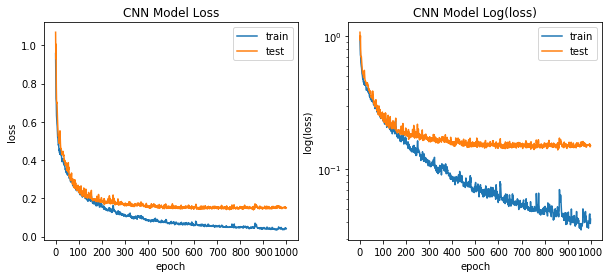

In [23]:
plot_loss_history(CNNmodel1)

In [24]:
cnn = CNN_model(in_dim, out_dim, filtersize=50)
cnn.compile(optimizer="adam", loss="mse")
CNNmodel = cnn.fit(Dtrain_1, aqtrain, validation_data=(Dtest_1, aqtest),
                  epochs=200, batch_size=120)

Train on 881 samples, validate on 221 samples
Epoch 1/200
881/881 [==============================] - 3s 3ms/step - loss: 1.3484 - val_loss: 1.1399
Epoch 2/200
881/881 [==============================] - 2s 2ms/step - loss: 0.9648 - val_loss: 1.1406
Epoch 3/200
881/881 [==============================] - 2s 2ms/step - loss: 0.9598 - val_loss: 1.1402
Epoch 4/200
881/881 [==============================] - 2s 2ms/step - loss: 0.9590 - val_loss: 1.1187
Epoch 5/200
881/881 [==============================] - 2s 2ms/step - loss: 0.9210 - val_loss: 1.0551
Epoch 6/200
881/881 [==============================] - 2s 2ms/step - loss: 0.8487 - val_loss: 0.9913
Epoch 7/200
881/881 [==============================] - 2s 2ms/step - loss: 0.7992 - val_loss: 0.9915
Epoch 8/200
881/881 [==============================] - 2s 2ms/step - loss: 0.7995 - val_loss: 0.8982
Epoch 9/200
881/881 [==============================] - 2s 2ms/step - loss: 0.7513 - val_loss: 0.9712
Epoch 10/200
881/881 [=======================

Epoch 81/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4186 - val_loss: 0.4626
Epoch 82/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4328 - val_loss: 0.4255
Epoch 83/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4242 - val_loss: 0.4405
Epoch 84/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4190 - val_loss: 0.4373
Epoch 85/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4121 - val_loss: 0.4312
Epoch 86/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4213 - val_loss: 0.4248
Epoch 87/200
881/881 [==============================] - 2s 2ms/step - loss: 0.4049 - val_loss: 0.4411
Epoch 88/200
881/881 [==============================] - 1s 2ms/step - loss: 0.4177 - val_loss: 0.4783
Epoch 89/200
881/881 [==============================] - 2s 2ms/step - loss: 0.4244 - val_loss: 0.4257
Epoch 90/200
881/881 [==============================] - 2s 2ms/step - loss: 0.4145

881/881 [==============================] - 2s 2ms/step - loss: 0.3469 - val_loss: 0.3023
Epoch 161/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3366 - val_loss: 0.2944
Epoch 162/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3382 - val_loss: 0.3376
Epoch 163/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3323 - val_loss: 0.3476
Epoch 164/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3532 - val_loss: 0.3171
Epoch 165/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3387 - val_loss: 0.3428
Epoch 166/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3560 - val_loss: 0.3185
Epoch 167/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3243 - val_loss: 0.2905
Epoch 168/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3264 - val_loss: 0.3112
Epoch 169/200
881/881 [==============================] - 2s 2ms/step - loss: 0.3149 - v

In [25]:
# model MSE on training and testing sets

train_mse = cnn.evaluate(Dtrain_1, aqtrain)
test_mse = cnn.evaluate(Dtest_1, aqtest)

print(train_mse, test_mse)

221/221 [==============================] - 0s 537us/step
0.23178300572713578 0.26773429281031924


### Predict Air Quality for training and Testing Sets

In [26]:
import time
start_time = time.time()

aqtrain_pred = cnn.predict(Dtrain_1)
aqtest_pred = cnn.predict(Dtest_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:00:00


In [27]:
print(aqtrain.shape)
print(aqtest.shape)

(881, 4)
(221, 4)


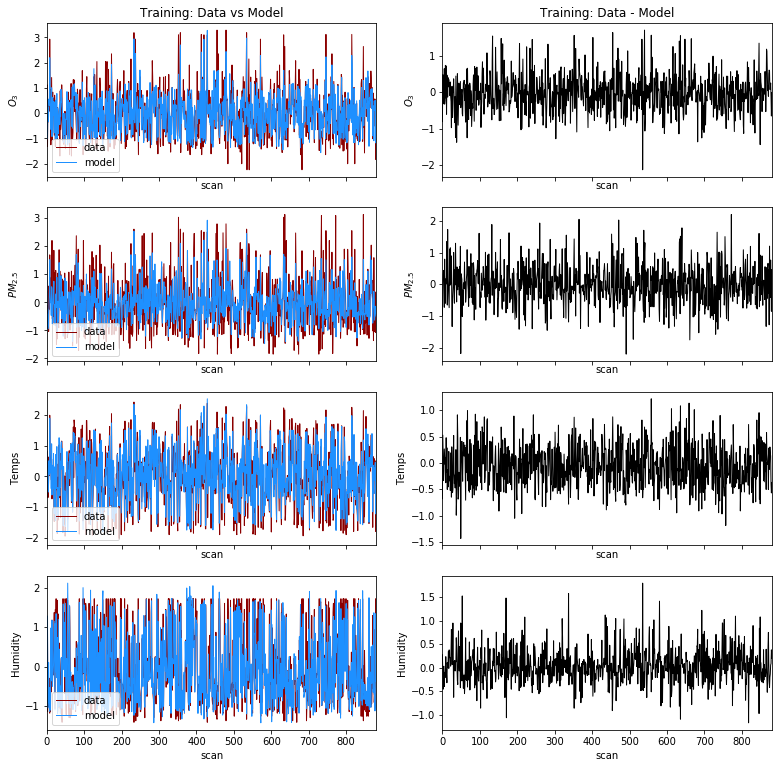

In [28]:
fig, axes = plt.subplots(aq_opth.shape[1], 2, figsize=(13, 13), sharex=True)
labels = [r'$O_3$', r'$PM_{2.5}$', 'Temps', 'Humidity']

axes[0,0].set_title('Training: Data vs Model')
for i in range(aq_opth.shape[1]):
    axes[i,0].plot(aqtrain[:,i], color="darkred",lw=1, label="data")
    axes[i,0].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,0].set_ylabel(labels[i])
    axes[i,0].legend(loc='lower left')
    axes[i,0].set_xlabel("scan")
    axes[i,0].set_xlim(0, aqtrain.shape[0])

axes[0,1].set_title('Training: Data - Model')
for i in range(aq_opth.shape[1]):
    axes[i,1].plot(aqtrain[:,i] - aqtrain_pred[:,i], color="black",lw=1)
    #axes[i,1].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,1].set_ylabel(labels[i])
    #axes[i,1].legend(loc='lower left')
    axes[i,1].set_xlabel("scan")
    axes[i,1].set_xlim(0, aqtrain.shape[0])
    
plt.show()

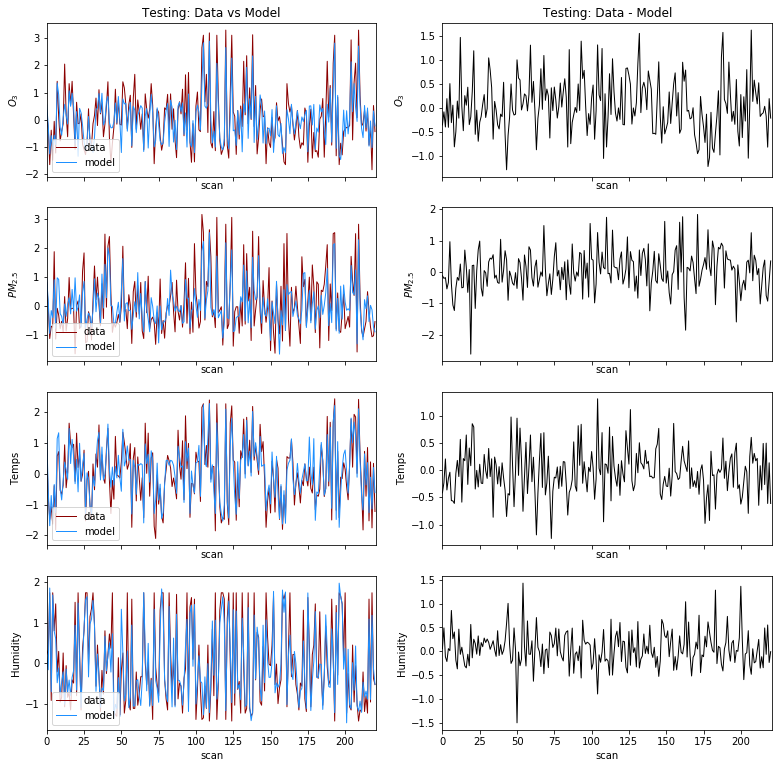

In [29]:
fig, axes = plt.subplots(aq_opth.shape[1], 2, figsize=(13, 13), sharex=True)
labels = [r'$O_3$', r'$PM_{2.5}$', 'Temps', 'Humidity']

axes[0,0].set_title('Testing: Data vs Model')
for i in range(aq_opth.shape[1]):
    axes[i,0].plot(aqtest[:,i], color="darkred",lw=1, label="data")
    axes[i,0].plot(aqtest_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,0].set_ylabel(labels[i])
    axes[i,0].legend(loc='lower left')
    axes[i,0].set_xlabel("scan")
    axes[i,0].set_xlim(0, aqtest.shape[0])

axes[0,1].set_title('Testing: Data - Model')
for i in range(aq_opth.shape[1]):
    axes[i,1].plot(aqtest[:,i] - aqtest_pred[:,i], color="black",lw=1)
    #axes[i,1].plot(aqtrain_pred[:,i], color="dodgerblue",lw=1, label="model")
    axes[i,1].set_ylabel(labels[i])
    #axes[i,1].legend(loc='lower left')
    axes[i,1].set_xlabel("scan")
    axes[i,1].set_xlim(0, aqtest.shape[0])
    
plt.show()